In [1]:
import  numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set_style("dark")
sns.set(rc={'figure.figsize':(12,8)})
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler 
from sklearn import linear_model, naive_bayes, neighbors, svm, tree, ensemble
from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("data/encoded.csv")
df.head(2)

,scoutId,telekomTvOffer,newlyConst,balcony,picturecount,pricetrend,telekomUploadSpeed,totalRent,yearConstructed,noParkSpaces,firingTypes,hasKitchen,cellar,condition,interiorQual,petsAllowed,streetPlain,lift,baseRentRange,geo_plz,thermalChar,floor,numberOfFloors,noRoomsRange,garden,livingSpaceRange,regio2,regio3,description,facilities,has_refurbished,floor_division,meter_price,regio1_Baden_Württemberg,regio1_Bayern,regio1_Berlin,regio1_Brandenburg,regio1_Hessen,regio1_Mecklenburg_Vorpommern,regio1_Niedersachsen,regio1_Nordrhein_Westfalen,regio1_Rheinland_Pfalz,regio1_Sachsen,regio1_Sachsen_Anhalt,regio1_Schleswig_Holstein,regio1_Thüringen,regio1_other,heatingType_central_heating,heatingType_district_heating,heatingType_floor_heating,heatingType_gas_heating,heatingType_no_heating,heatingType_other,heatingType_self_contained_central_heating,typeOfFlat_apartment,typeOfFlat_bad_flat,typeOfFlat_ground_floor,typeOfFlat_maisonette,typeOfFlat_other,typeOfFlat_penthouse,typeOfFlat_raised_ground_floor,typeOfFlat_roof_storey,typeOfFlat_terraced_flat
0,96107057,2,False,False,6,4.62,10.0,840.0,1965.0,1.0,oil,False,True,3,2,1,Schüruferstraße,False,4,44269,181.4,1.0,3.0,4,True,4,Dortmund,Schüren,Die ebenerdig zu erreichende Erdgeschosswohnun...,Die Wohnung ist mit Laminat ausgelegt. Das Bad...,False,0.3333,6.918,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,111378734,2,False,True,8,3.47,10.0,934.0,1871.0,2.0,gas,False,False,1,2,0,other,False,5,67459,113.3,2.0,3.0,3,False,4,Rhein_Pfalz_Kreis,Böhl_Iggelheim,Alles neu macht der Mai – so kann es auch für ...,other,True,0.6665,8.990,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0


In [4]:
df.set_index('scoutId', inplace=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254498 entries, 96107057 to 110938302
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   telekomTvOffer                              254498 non-null  int64  
 1   newlyConst                                  254498 non-null  bool   
 2   balcony                                     254498 non-null  bool   
 3   picturecount                                254498 non-null  int64  
 4   pricetrend                                  254498 non-null  float64
 5   telekomUploadSpeed                          254498 non-null  float64
 6   totalRent                                   254498 non-null  float64
 7   yearConstructed                             254498 non-null  float64
 8   noParkSpaces                                254498 non-null  float64
 9   firingTypes                                 254498 non-null 

In [5]:
# From : https://www.mikulskibartosz.name/how-to-reduce-memory-usage-in-pandas/

def reduce_mem_usage(df, int_cast=True, obj_to_category=False, subset=None):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.
    :param df: dataframe to reduce (pd.DataFrame)
    :param int_cast: indicate if columns should be tried to be casted to int (bool)
    :param obj_to_category: convert non-datetime related objects to category dtype (bool)
    :param subset: subset of columns to analyse (list)
    :return: dataset with the column dtypes adjusted (pd.DataFrame)
    """
    start_mem = df.memory_usage().sum() / 1024 ** 2;
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object and col_type.name not in ['category', 'bool'] and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()

            # test if column can be converted to an integer
            treat_as_int = str(col_type)[:3] == 'int'

            if treat_as_int:
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.uint8).min and c_max < np.iinfo(np.uint8).max:
                    df[col] = df[col].astype(np.uint8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.uint16).min and c_max < np.iinfo(np.uint16).max:
                    df[col] = df[col].astype(np.uint16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.uint32).min and c_max < np.iinfo(np.uint32).max:
                    df[col] = df[col].astype(np.uint32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.uint64).min and c_max < np.iinfo(np.uint64).max:
                    df[col] = df[col].astype(np.uint64)
            elif str(col_type)[:4] == 'uint':
                pass
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name and obj_to_category:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.3f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [6]:
df = reduce_mem_usage(df)
df.info()

Memory usage of dataframe is 110.43 MB
Memory usage after optimization is: 30.339 MB
Decreased by 72.5%
<class 'pandas.core.frame.DataFrame'>
Int64Index: 254498 entries, 96107057 to 110938302
Data columns (total 62 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   telekomTvOffer                              254498 non-null  int8   
 1   newlyConst                                  254498 non-null  bool   
 2   balcony                                     254498 non-null  bool   
 3   picturecount                                254498 non-null  int8   
 4   pricetrend                                  254498 non-null  float16
 5   telekomUploadSpeed                          254498 non-null  float16
 6   totalRent                                   254498 non-null  float16
 7   yearConstructed                             254498 non-null  float16
 8   noParkSpaces                  

In [7]:
def drop_str_vars(df):
    '''
    Drops remained object variables from the dataset
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        the final dataframe 
    '''
    
    cols = []
    for col in df.columns:
        name = df[col].dtype.name
        if name == "object":
            cols.append(col)

    df.drop(cols, inplace=True, axis=1)
    return df        

In [8]:
df = drop_str_vars(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254498 entries, 96107057 to 110938302
Data columns (total 56 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   telekomTvOffer                              254498 non-null  int8   
 1   newlyConst                                  254498 non-null  bool   
 2   balcony                                     254498 non-null  bool   
 3   picturecount                                254498 non-null  int8   
 4   pricetrend                                  254498 non-null  float16
 5   telekomUploadSpeed                          254498 non-null  float16
 6   totalRent                                   254498 non-null  float16
 7   yearConstructed                             254498 non-null  float16
 8   noParkSpaces                                254498 non-null  float16
 9   hasKitchen                                  254498 non-null 

In [9]:
def numeric_features(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Extract names of numeric features in the dataframe
    Arguments:
        df is a n-by-d pandas data frame
    Returns:
        list contains names of numeric featuers 
    '''
    
    skew, kurtosis, num_features = [], [], []
    for feature in df.columns:
        if df[feature].dtype.name not in ['int8', 'bool']:
            num_features.append(feature)
    return num_features

In [10]:
num_features = numeric_features(df)
print(num_features)

['pricetrend', 'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'noParkSpaces', 'geo_plz', 'thermalChar', 'floor', 'numberOfFloors', 'floor_division', 'meter_price']


array([[<AxesSubplot:title={'center':'pricetrend'}>,
        <AxesSubplot:title={'center':'telekomUploadSpeed'}>,
        <AxesSubplot:title={'center':'totalRent'}>],
       [<AxesSubplot:title={'center':'yearConstructed'}>,
        <AxesSubplot:title={'center':'noParkSpaces'}>,
        <AxesSubplot:title={'center':'geo_plz'}>],
       [<AxesSubplot:title={'center':'thermalChar'}>,
        <AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'numberOfFloors'}>],
       [<AxesSubplot:title={'center':'floor_division'}>,
        <AxesSubplot:title={'center':'meter_price'}>, <AxesSubplot:>]],
      dtype=object)

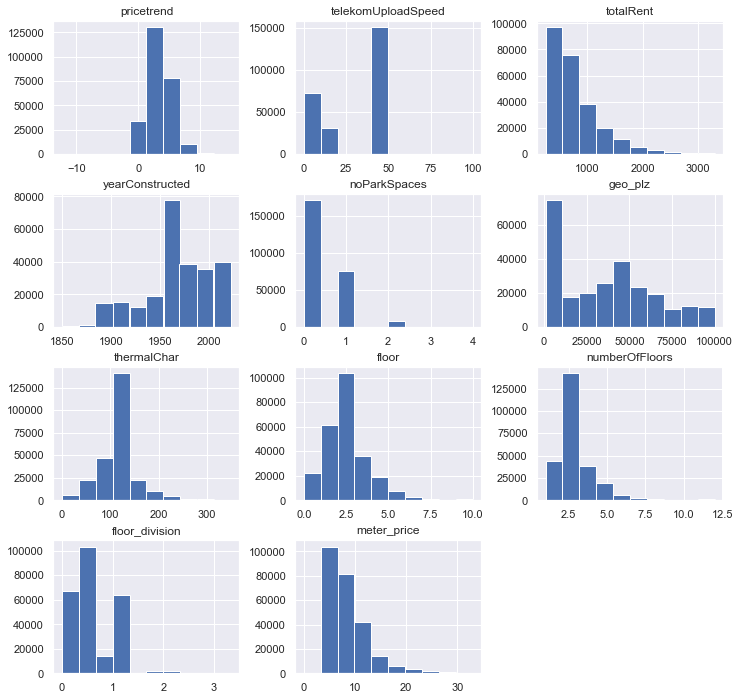

In [73]:
df[num_features].hist(layout=(4, 3), figsize=(12, 12))

In [11]:
df_X = df.drop('totalRent', axis=1)
df_y = df['totalRent']
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.05, stratify=df_X['baseRentRange'], random_state=42)
print("Train size: ", X_train.shape, y_train.shape)
print("Test size: ", X_test.shape, y_test.shape)

Train size:  (241773, 55) (241773,)
Test size:  (12725, 55) (12725,)


In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [13]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
print(X_train_pca.shape)

(241773, 43)


In [14]:
models = [
    linear_model.LinearRegression(),
    linear_model.SGDRegressor(),
    tree.DecisionTreeRegressor(),
    tree.ExtraTreeRegressor(),
    ensemble.AdaBoostRegressor(),
    ensemble.BaggingRegressor(),
    ensemble.ExtraTreesRegressor(),
    ensemble.GradientBoostingRegressor(),
    ensemble.RandomForestRegressor(),
]

model_result_columns = ['Model Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy Mean', 'Time']
model_result = pd.DataFrame(columns=model_result_columns)

cv_split = ShuffleSplit(n_splits=5, test_size=.3, train_size=.6, random_state=0)

for index, model in enumerate(models):
    print("Working on ", index)
    model_result.loc[index, 'Model Name'] = model.__class__.__name__
    model_result.loc[index, 'Parameters'] = str(model.get_params())

    cv_result = cross_validate(model, X_train_pca, y_train, cv=cv_split, n_jobs=5, return_train_score=True, scoring='neg_root_mean_squared_error')
    
    model_result.loc[index, 'Time'] = cv_result['fit_time'].mean()
    model_result.loc[index, 'Train Accuracy Mean'] = cv_result['train_score'].mean()
    model_result.loc[index, 'Test Accuracy Mean'] = cv_result['test_score'].mean() 

model_result.sort_values(by=['Test Accuracy Mean'], ascending=False, inplace=True)
model_result

Working on  0
Working on  1
Working on  2
Working on  3
Working on  4
Working on  5
Working on  6
Working on  7
Working on  8


,Model Name,Parameters,Train Accuracy Mean,Test Accuracy Mean,Time
6,ExtraTreesRegressor,"{'bootstrap': False, 'ccp_alpha': 0.0, 'criter...",-1.235185,-154.319717,267.096664
8,RandomForestRegressor,"{'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...",-59.572857,-158.36372,781.518034
5,BaggingRegressor,"{'base_estimator': None, 'bootstrap': True, 'b...",-73.22008,-169.181365,80.883987
7,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-171.612386,-174.585358,342.331333
0,LinearRegression,"{'copy_X': True, 'fit_intercept': True, 'n_job...",-190.702583,-190.473791,1.353555
1,SGDRegressor,"{'alpha': 0.0001, 'average': False, 'early_sto...",-191.453469,-191.298574,1.709662
2,DecisionTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",-1.235114,-244.385982,13.045181
3,ExtraTreeRegressor,"{'ccp_alpha': 0.0, 'criterion': 'squared_error...",-1.235183,-255.433396,3.008085
4,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",-366.684082,-367.346549,96.585591


In [14]:
param_grid_et = [
    {
        'criterion': ['squared_error', 'absolute_error'],
        'n_estimators': np.arange(200, 2000, 10),
        'max_depth': np.arange(10, 100, 10),
        "min_samples_split": np.arange(2, 10),
        "min_samples_leaf": [1, 3, 5, 7, 10],
        "max_features": [None, "auto", "log2"],
        "bootstrap": [True, False],
    }
]

tune_model_et = RandomizedSearchCV(ensemble.ExtraTreesRegressor(), n_iter=20,
                                   param_distributions=param_grid_et,
                                   scoring='neg_root_mean_squared_error',
                                   cv=3, n_jobs=5, return_train_score=True)
tune_model_et.fit(X_train_pca, y_train)

print("best parameters: ", tune_model_et.best_params_)
print("Mean train score: ", tune_model_et.cv_results_['mean_train_score'][tune_model_et.best_index_] * 100)
print("Mean test Score: ", tune_model_et.cv_results_['mean_test_score'][tune_model_et.best_index_] * 100)

# can not tune the model since the dataset is to large and the cell does not answering for around 12 hours
# so I will use the defualt hyperparameters for the final model.

In [15]:
model_et = ensemble.ExtraTreesRegressor()

model_et.fit(X_train_pca, y_train)
y_hat = model_et.predict(X_train_pca)
print("Train RMSE:", mean_squared_error(y_train, y_hat, squared=False))
y_hat_test = model_et.predict(X_test_pca)
print("Test RMSE:", mean_squared_error(y_test, y_hat_test, squared=False))

Train RMSE: 2.0045450802468294
Test RMSE: 149.32947399267076


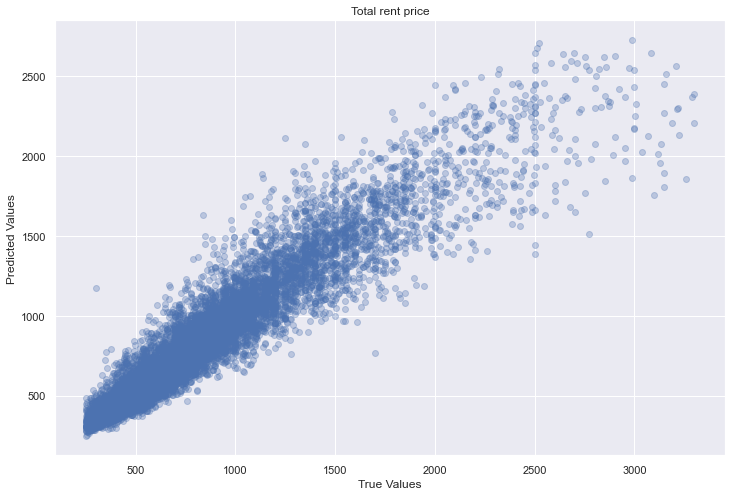

In [44]:
plt.scatter(y_test, y_hat_test, alpha=.3)
axis = plt.gca()
axis.set_xlabel("True Values")
axis.set_ylabel("Predicted Values")
plt.title("Total rent price")
plt.show()